# Estimating External Worker Identification Model

This notebook re-estimates ActivitySim external worker identification model in Larch. 

# Load libraries

In [29]:
import os
import larch  # !conda install larch -c conda-forge # for estimation
import pandas as pd
import numpy as np
from larch import P, X
import matplotlib.pyplot as plt

The directory with the estimation data bundles for tour mode choice.

In [30]:
os.chdir('/projects/SANDAG/2017 On-Call Modeling Services/Area B/TO 05 - ABM3/estimation/output/estimation_data_bundle/external_worker_identification')

# Drop duplicate person records

In [31]:
alts_combined_data = pd.read_csv("external_worker_identification_values_combined_orig.csv", dtype={'household_id': np.int64},low_memory=False)
#household_data = pd.read_csv("../override_households.csv",dtype={'household_id': np.int64})
#person_data = pd.read_csv("../override_persons.csv")
alts_combined_data.shape

(45439, 271)

In [32]:
#merge alts_combined data with person file
#alts_combined_per_data = pd.merge(alts_combined_data, person_data[['person_id','PNUM']], on=["person_id"], how='left')
#alts_combined_per_data.shape

In [33]:
#merge alts_combined data (with person file) with household file
#alts_combined_hh_data = pd.merge(alts_combined_data, household_data[['household_id','HH_ID']], on=["household_id"], how='left')
#alts_combined_hh_data.shape

In [34]:
#drop duplicate person records and merged columns
alts_combined_data = alts_combined_data.sort_values(by=['override_choice'])
alts_combined_new_data = alts_combined_data.drop_duplicates(subset=['HH_ID','PNUM'])
alts_combined_new_data = alts_combined_new_data[alts_combined_new_data['is_worker']==True]
#alts_combined_new_data = alts_combined_new_data.drop(columns=['household_id','PNUM','HH_ID'])
alts_combined_new_data.shape

(8074, 271)

In [35]:
pd.crosstab(alts_combined_new_data.closest_external_zone, alts_combined_new_data.override_choice, margins=True)

override_choice,0,1,All
closest_external_zone,,,
24323,0,2,2
24324,1,3,4
24325,2,30,32
24326,63,1137,1200
24327,28,499,527
24328,43,5143,5186
24329,9,1082,1091
24330,1,31,32
All,147,7927,8074


In [36]:
#recalculate util_2016 based on survey year
alts_combined_new_data['util_2016'] = np.where(alts_combined_new_data['survey_year']==2016,1,0)
alts_combined_new_data['util_part_time'] = np.where(alts_combined_new_data['is_parttime_worker']==True,1,0)

In [37]:
#write data to file
if os.path.exists("external_worker_identification_values_combined_orig.csv")!=True:
  shutil.copy2('external_worker_identification_values_combined.csv','external_worker_identification_values_combined_orig.csv')
alts_combined_new_data.to_csv("external_worker_identification_values_combined.csv", index=False)

# Load data and prep model for estimation

In [38]:
os.chdir('/projects/SANDAG/2017 On-Call Modeling Services/Area B/TO 05 - ABM3/estimation')
modelname = "external_worker_identification"

from activitysim.estimation.larch import component_model
model, data = component_model(modelname, return_data=True)

c:\development\projects\sandag_activitysim\activitysim\estimation\larch\simple_simulate.py:66: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(os.path.join(edb_directory, filename), **kwargs)


# Review data loaded from the EDB

The next step is to read the EDB, including the coefficients, model settings, utilities specification, and chooser and alternative data.

### Coefficients

In [39]:
data.coefficients

,value,constrain
coefficient_name,,
coef_dist_to_nearest_ext_station,0,F
coef_size_of_nearest_ext_station,0,F
coef_part_time,0,F
asc_external_worker,0,F
coef_agriculture,0,F
asc_external_2016,0,F
coef_inc_lt15,0,F
coef_inc_25_50,0,F
coef_inc_250plus,0,F


#### Utility specification

In [40]:
data.spec

,Label,Description,Expression,work_external,work_internal
0,util_dist_to_nearest_ext_station,Distance to nearest external station,dist_to_external_zone,coef_dist_to_nearest_ext_station,NaN
1,util_size_of_nearest_ext_station,Size of nearest external station,"@np.log1p(reindex(land_use.external_work,df.cl...",coef_size_of_nearest_ext_station,NaN
2,util_dist_lt_2p5,Distance less than 2.5 miles,"@np.where(df.dist_to_external_zone<2.5,1,0)",coef_dist_lt_2p5,NaN
3,util_part_time,Part time worker,"@np.where(df.is_parttime_worker==""TRUE"",1,0)",coef_part_time,NaN
4,util_inc_lt15,Household Income less than $15k,@(df.income<15000),coef_inc_lt15,NaN
5,util_inc_15_25,Household income $15k-$25k,@(df.income>=15000) & (df.income<25000),coef_inc_15_25,NaN
6,util_inc_25_50,Household Income $25k-$50k,@(df.income>=25000) & (df.income<50000),coef_inc_25_50,NaN
7,util_inc_150_250,Household Income $150k-$50k,@(df.income>=150000) * (df.income<250000),coef_inc_150_250,NaN
8,util_inc_250plus,Household Income $250k+,@(df.income>=250000),coef_inc_250plus,NaN
9,util_asc,Alternative-specific constant for external worker,1,asc_external_worker,NaN


## Explore data

In [41]:
data.chooser_data

,model_choice,override_choice,util_dist_to_nearest_ext_station,util_size_of_nearest_ext_station,util_dist_lt_2p5,util_part_time,util_inc_lt15,util_inc_15_25,util_inc_25_50,util_inc_150_250,...,household_density,population_density,employment_density,density_index,is_cbd,tot_collegeenroll,preschool_target,is_parking_zone,closest_external_zone,dist_to_external_zone
person_id,,,,,,,,,,,,,,,,,,,,,
34695,1,0,36.952385,8.519471,0.0,0,0.0,0.0,0.0,0.0,...,11.551207,35.726685,4.670980,3.326029,False,0,640,True,24328,36.952385
88812,1,0,18.992023,8.519471,0.0,0,0.0,0.0,0.0,1.0,...,40.005715,85.726532,34.647807,18.567246,False,0,298,True,24328,18.992023
29807,1,0,28.078810,10.756881,0.0,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,False,0,0,True,24326,28.078810
7772,1,0,24.396740,10.051520,0.0,0,0.0,0.0,1.0,0.0,...,2.712262,7.207930,0.705931,0.560141,False,0,213,True,24327,24.396740
11399,1,0,25.715353,10.756881,0.0,0,0.0,0.0,1.0,0.0,...,8.484787,24.605882,0.127272,0.125391,False,0,583,True,24326,25.715353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31545,1,1,20.862137,8.519471,0.0,0,0.0,0.0,0.0,0.0,...,10.192849,23.647409,0.000000,0.000000,False,0,116,True,24328,20.862137
31012,1,1,16.555700,8.519471,0.0,0,0.0,0.0,1.0,0.0,...,58.364407,138.268059,49.100215,26.666496,False,0,809,True,24328,16.555700
30702,1,1,23.222313,10.756881,0.0,1,0.0,0.0,0.0,0.0,...,0.000000,0.000000,4.667445,0.000000,False,0,0,True,24326,23.222313


In [42]:
pd.crosstab(data.chooser_data.closest_external_zone, data.chooser_data.override_choice, margins=True)

override_choice,0,1,All
closest_external_zone,,,
24323,0,2,2
24324,1,3,4
24325,2,30,32
24326,63,1137,1200
24327,28,499,527
24328,43,5143,5186
24329,9,1082,1091
24330,1,31,32
All,147,7927,8074


In [43]:
pd.crosstab(data.chooser_data.industry, data.chooser_data.override_choice, margins=True, normalize='index')

override_choice,0,1
industry,,
0,0.020000,0.980000
accomodation,0.000000,1.000000
agriculture,0.088889,0.911111
business_srv,0.018018,0.981982
construction,0.027397,0.972603
education,0.018921,0.981079
entertainment,0.024221,0.975779
food_srv,0.015873,0.984127
government,0.010256,0.989744


In [44]:
pd.crosstab(data.chooser_data.industry, data.chooser_data.override_choice, margins=True)

override_choice,0,1,All
industry,,,
0,3,147,150
accomodation,0,179,179
agriculture,4,41,45
business_srv,22,1199,1221
construction,16,568,584
education,20,1037,1057
entertainment,7,282,289
food_srv,4,248,252
government,2,193,195


In [45]:
data.chooser_data['external_worker'] = np.where(data.chooser_data["override_choice"]==1,0,1)

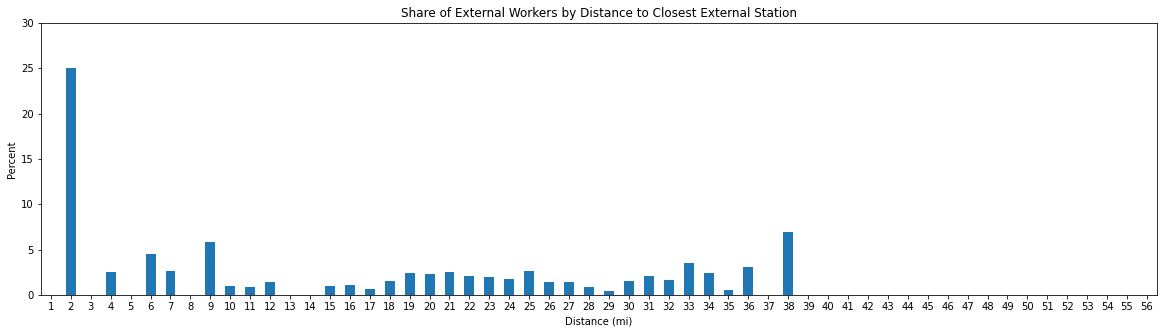

In [46]:
#plt.hist(data.chooser_data['distance_int'],range=(0, data.chooser_data['distance_int'].max()), bins=data.chooser_data['distance_int'].max() + 1)
data.chooser_data['distance_int']=data.chooser_data['util_dist_to_nearest_ext_station'].astype(int)
plot_df = data.chooser_data.groupby('distance_int')['external_worker'].mean().mul(100).reindex(range(data.chooser_data.distance_int.min()-1,data.chooser_data.distance_int.max()+1), fill_value=0)

ax = plot_df.plot(kind='bar',rot = 0,title='Share of External Workers by Distance to Closest External Station',ylim=[0, 30], xlabel="Distance (mi)", ylabel="Percent",  figsize=(20, 5))

plt.show()

In [47]:
chooser_data_lt1mi= data.chooser_data[data.chooser_data["distance_int"]<=2]
pd.crosstab(chooser_data_lt1mi.closest_external_zone, chooser_data_lt1mi.override_choice, margins=True)

override_choice,0,1,All
closest_external_zone,,,
24327,1,2,3
24328,0,1,1
All,1,3,4


# Set Coefficients

In [48]:
dir(model)
print(model.utility_co)

DictOfLinearFunction_C({0:   P.coef_dist_to_nearest_ext_station * X.util_dist_to_nearest_ext_station
+ P.coef_size_of_nearest_ext_station * X.util_size_of_nearest_ext_station
+ P.coef_dist_lt_2p5 * X.util_dist_lt_2p5
+ P.coef_part_time * X.util_part_time
+ P.coef_inc_lt15 * X.util_inc_lt15
+ P.coef_inc_15_25 * X.util_inc_15_25
+ P.coef_inc_25_50 * X.util_inc_25_50
+ P.coef_inc_150_250 * X.util_inc_150_250
+ P.coef_inc_250plus * X.util_inc_250plus
+ P.asc_external_worker * X.util_asc
+ P('-999') * X.util_global_switch
+ P.asc_external_2016 * X.util_2016, 1: <Empty LinearFunction_C>})


In [49]:
#model.utility_co = {0: P.coef_dist_to_nearest_ext_station * X.util_dist_to_nearest_ext_station
#+ P.coef_size_of_nearest_ext_station * X.util_size_of_nearest_ext_station
#+ P.coef_part_time * X.parttime
#+ P.coef_agriculture * X.agriculture
#+ P.coef_business_srv * X.business_srv
#+ P.coef_construction * X.construction
#+ P.coef_education * X.education
#+ P.coef_entertainment * X.entertainment
#+ P.coef_food_srv * X.food_srv                   
#+ P.coef_government * X.government
#+ P.coef_healthcare * X.healthcare                   
#+ P.coef_manufacturing * X.manufacturing
#+ P.coef_mgmt_srv * X.mgmt_srv
#+ P.coef_military * X.military
#+ P.coef_retail * X.retail    
#+ P.coef_inc_lt15 * X("income<15000")
#+ P.coef_inc_15_25 * X("(income>=15000) * (income<25000)") 
#+ P.coef_inc_25_50 * X("(income>=25000) * (income<50000)") 
#+ P.coef_inc_100_150 * X.income_100_150 
#+ P.coef_inc_150_250 * X("(income>=150000) * (income<250000)")  
#+ P.coef_inc_250plus * X("income>=250000")
#+ P.asc_external_2016 * X.year_2016         
#+ P.coef_dist_lt_2p5 * X("util_dist_to_nearest_ext_station<2.5")                    
#+ P.asc_external_worker * X.util_asc_placeholder, 1: 0}

# Estimate

With the model setup for estimation, the next step is to estimate the model coefficients.  Make sure to use a sufficiently large enough household sample and set of zones to avoid an over-specified model, which does not have a numerically stable likelihood maximizing solution.  Larch has a built-in estimation methods including BHHH, and also offers access to more advanced general purpose non-linear optimizers in the `scipy` package, including SLSQP, which allows for bounds and constraints on parameters.  BHHH is the default and typically runs faster, but does not follow constraints on parameters.

In [50]:
model.load_data()
#model.doctor(repair_ch_av="-")

req_data does not request avail_ca or avail_co but it is set and being provided
converting data_co to <class 'numpy.float64'>


In [51]:
model.maximize_loglike(method="SLSQP", options={"maxiter": 1000})


,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
-999,-999.000000,-999.0,-999.0,-999.0,-999.0,1,,-999.000000
asc_external_2016,0.710841,0.0,0.0,NaN,NaN,0,,0.710841
asc_external_worker,-10.723198,0.0,0.0,NaN,NaN,0,,-10.723198
coef_dist_lt_2p5,2.302816,0.0,0.0,NaN,NaN,0,,2.302816
coef_dist_to_nearest_ext_station,-0.036378,0.0,0.0,NaN,NaN,0,,-0.036378
coef_inc_150_250,0.831648,0.0,0.0,NaN,NaN,0,,0.831648
coef_inc_15_25,-0.933483,0.0,0.0,NaN,NaN,0,,-0.933483
coef_inc_250plus,1.229674,0.0,0.0,NaN,NaN,0,,1.229674
coef_inc_25_50,-0.573397,0.0,0.0,NaN,NaN,0,,-0.573397
coef_inc_lt15,-1.331420,0.0,0.0,NaN,NaN,0,,-1.331420


┣                x: -999                               -999.000000
┃                   asc_external_2016                     0.710841
┃                   asc_external_worker                 -10.723198
┃                   coef_dist_lt_2p5                      2.302816
┃                   coef_dist_to_nearest_ext_station     -0.036378
┃                   coef_inc_150_250                      0.831648
┃                   coef_inc_15_25                       -0.933483
┃                   coef_inc_250plus                      1.229674
┃                   coef_inc_25_50                       -0.573397
┃                   coef_inc_lt15                        -1.331420
┃                   coef_part_time                       -0.222814
┃                   coef_size_of_nearest_ext_station      0.789044
┃                   dtype: float64
┣          loglike: -669.6747850028331
┣        d_loglike: -999                                0.000000
┃                   asc_external_2016                   0.000638
┃                   asc_external_worker                 0.002735
┃                   coef_dist_lt_2p5                    0.000006
┃                   coef_dist_to_nearest_ext_station    0.053390
┃                   coef_inc_150_250                    0.000670
┃                   coef_inc_15_25                      0.000065
┃                   coef_inc_250plus                   -0.000058
┃                   coef_inc_25_50                      0.000340
┃                   coef_inc_lt15                      -0.000106
┃                   coef_part_time                      0.000537
┃                   coef_size_of_nearest_ext_station    0.026282
┃                   dtype: float64
┣              nit: 31
┣             nfev: 56
┣             njev: 31
┣           status: 0
┣          message: 'Optimization terminated successfully'
┣          success: True
┣     elapsed_time: datetime.timedelta(seconds=5, microseconds=653623)
┣           method: 'SLSQP'
┣          n_cases: 8074
┣ iteration_number: 31
┣          logloss: 0.08294213339148292

### Estimated coefficients

In [52]:
model.calculate_parameter_covariance()
result_dir='/projects/SANDAG/2017 On-Call Modeling Services/Area B/TO 05 - ABM3/estimation/'
model.to_xlsx(
        result_dir+"ext_worker_id_003.xlsx", 
        data_statistics=True,
    )

C:\Users\joel.freedman\Anaconda3\envs\asim_est\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)


# Output Estimation Results

In [53]:
from activitysim.estimation.larch import update_coefficients
result_dir = data.edb_directory/"estimated"
update_coefficients(
    model, data, result_dir,
    output_file=f"{modelname}_coefficients_003.csv",
);

In [54]:
#larch.__version__

In [55]:
#result_dir

### Write the model estimation report, including coefficient t-statistic and log likelihood

# Next Steps

The final step is to either manually or automatically copy the `*_coefficients_revised.csv` file to the configs folder, rename it to `*_coefficients.csv`, and run ActivitySim in simulation mode.

In [56]:
#pd.read_csv(result_dir/f"{modelname}_coefficients_revised.csv")